In [1]:
import pandas
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

## Получаем данные по 2 и 3-й группе

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# данные АА-теста с '2022-12-25' по '2022-12-31'
query = '''
SELECT exp_group, user_id,
    sum(action = 'like') as likes, 
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2022-12-25' 
    AND toDate(time) <= '2022-12-31'
    AND exp_group in (2,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [4]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [5]:
df.shape

(17049, 5)

In [6]:
# проверили разбиение
df.groupby('exp_group').count().user_id

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

In [7]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

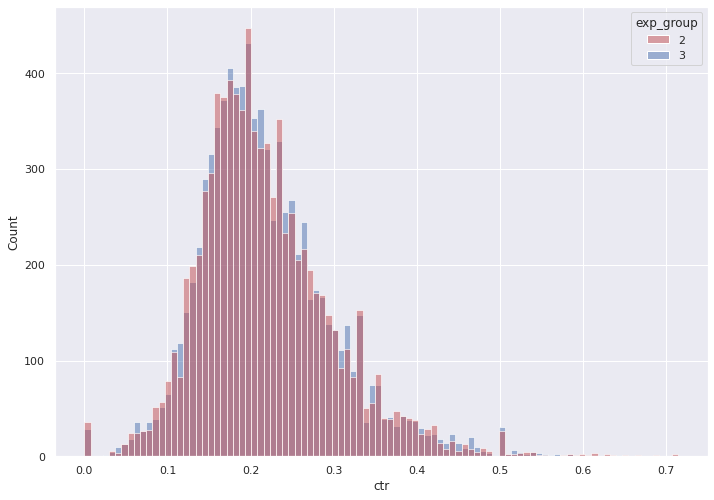

In [8]:
# Посмотрим на распределение ctr в двух группах
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [9]:
import random


def get_p_values(iterations, subsample_size, sample_1, sample_2):
    p_values = np.empty(iterations)
    for i in range(iterations):
        sub_1 = np.random.choice(sample_1, subsample_size, replace=False)
        sub_2 = np.random.choice(sample_2, subsample_size, replace=False)
        
        #сравниваем получившиеся подвыборки с помощью t-test
        p_values[i] = stats.ttest_ind(sub_1, sub_2, equal_var=False)[1]
    return p_values
        
        

In [10]:
# сделаем симуляцию, как будто мы провели 10000 АА-тестов
sample_1 = df[df.exp_group == 2].ctr.to_numpy()
sample_2 = df[df.exp_group == 3].ctr.to_numpy()
subsample_size = 500 
iterations = 10000

p_values = get_p_values(iterations,subsample_size,sample_1,sample_2)

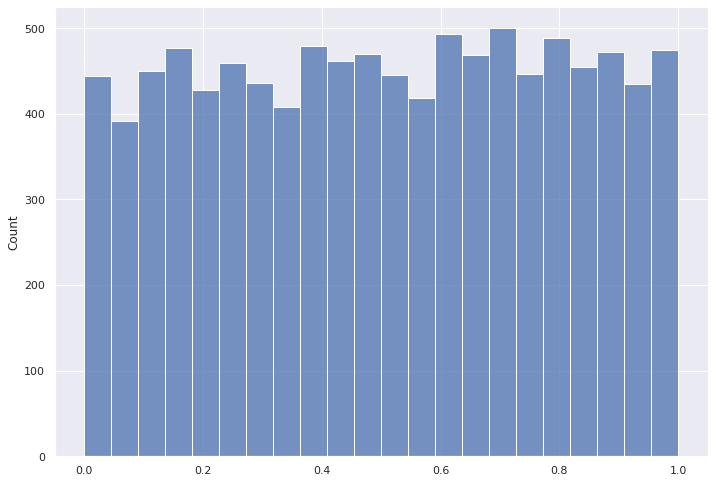

In [11]:
#гистограмма распределения получившихся 10000 p-values
sns.histplot(p_values)
plt.show()

In [72]:
print(f'Процент p_values, который меньше либо равен 0.05: {len(p_values[p_values <= 0.05]) / len(p_values) * 100}%')

Процент p_values, который меньше либо равен 0.05: 4.29%


Вывод: система сплитования работает корректно, потому что распределение p-value равномерно, значит можно сказать, что выборки не отличаются друг от друга